In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Sun Jan 14 21:47:09 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   25C    P8    14W / 230W |      8MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.latent_layer.uniform_min_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [21]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 3
hp.out_dim = 3
hp.z_dim = 128
hp.h_dims = [32, 64, 128, 256, 512]

In [22]:
step = 0
device = 'cuda:0'

model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))
        
print('done')

encoder 6.99169921875
encoder.convs 5.9912109375
encoder.linear 1.00048828125
latent_layer 0.0
decoder 7.028697967529297
decoder.linear 1.0078125
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [23]:
save_dir = '/data/scpark/save/lse/train01.14-7/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, net_g, _, opt_g, _ = load(save_dir, 0, model, optimizer)

total 0
-rw-rw-r-- 1 scpark scpark 0  1월 14 21:47 events.out.tfevents.1705236455.GPUSVR01


### Dataset

In [24]:
from torchvision import datasets, transforms
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

# Transformations applied on each image
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.CenterCrop(148),
                                transforms.Resize(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])

# Load the MNIST dataset
trainset = MyCelebA(
            '/data',
            split='train',
            transform=transform,
            download=False,
        )
testset = MyCelebA(
            '/data',
            split='test',
            transform=transform,
            download=False,
        )

# Create data loaders
train_loader = DataLoader(trainset, batch_size=256, shuffle=True)
test_loader = DataLoader(testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [40]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [41]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    _x = (_x + 1) * 127.5
    _x = _x.astype(np.uint8)
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        data = preprocess(batch)
        
        # Forward
        model.train()
        model.zero_grad()
        data = model(data, M=1024)
        
        # Backward
        loss = 0
        for key in data.keys():
            if 'loss' in key:
                loss = loss + data[key]
                writer.add_scalar(key, data[key].item(), step)
                print(key, data[key].item())
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model.eval()
            with torch.no_grad():
                data = model(data, M=1024)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = ((torch.rand(10, hp.z_dim) * 2) - 1).to(device)
                y = model.sample(z)
                plot(y)
                
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        

4018
lse_loss 40.185821533203125
recon_loss 0.05534706637263298
4019
lse_loss 40.33433532714844
recon_loss 0.06201763078570366
4020
lse_loss 40.052635192871094
recon_loss 0.05954110622406006
4021
lse_loss 40.151344299316406
recon_loss 0.06012263149023056
4022
lse_loss 40.11608123779297
recon_loss 0.05679868906736374
4023
lse_loss 40.050437927246094
recon_loss 0.05924326181411743
4024
lse_loss 40.13329315185547
recon_loss 0.06299559026956558
4025
lse_loss 40.28270721435547
recon_loss 0.05569557473063469
4026
lse_loss 40.24482345581055
recon_loss 0.05834906920790672
4027
lse_loss 40.26417541503906
recon_loss 0.05572141706943512
4028
lse_loss 40.23345947265625
recon_loss 0.06058148294687271
4029
lse_loss 40.3672981262207
recon_loss 0.059053145349025726
4030
lse_loss 40.329246520996094
recon_loss 0.0604977123439312
4031
lse_loss 40.02509307861328
recon_loss 0.05774815008044243
4032
lse_loss 39.868568420410156
recon_loss 0.058981359004974365
4033
lse_loss 40.29426193237305
recon_loss 0.0584

4148
lse_loss 40.232887268066406
recon_loss 0.06434701383113861
4149
lse_loss 40.093910217285156
recon_loss 0.06493943929672241
4150
lse_loss 39.992713928222656
recon_loss 0.0634768009185791
4151
lse_loss 40.129066467285156
recon_loss 0.06407802551984787
4152
lse_loss 40.10307693481445
recon_loss 0.055665791034698486


In [43]:
save(save_dir, step, model, optimizer)

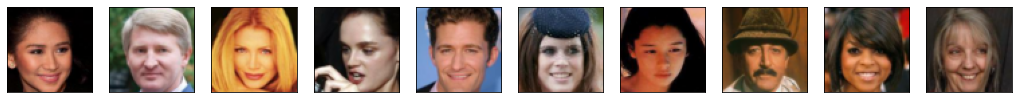

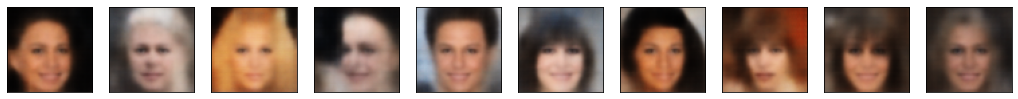

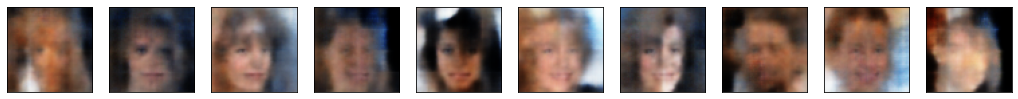

In [45]:
import matplotlib.pyplot as plt
display.clear_output()

batch = next(iter(test_loader))
data = preprocess(batch)

model.eval()
with torch.no_grad():
    data = model(data, M=1024)

plot(data['x'])
plot(data['y'])

with torch.no_grad():
    z = ((torch.rand(10, hp.z_dim) * 2) - 1).to(device)
    y = model.sample(z)
    plot(y)